# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных  
Даны геологоразведки трёх регионов:
- id — уникальный идентификатор скважины;  
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler



In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tabulate import tabulate

In [4]:
BUDGET = 10_000_000_000
BENEFIT = 450000
POINTS = 200

In [5]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
display(data_0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
display(data_1.head())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
data_2 = pd.read_csv('/datasets/geo_data_2.csv')
display(data_2.head())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
data_2 .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет, все столбцы численные. Проверим мультиколлинеарность.

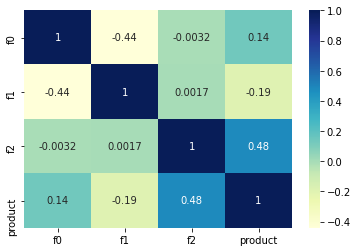

In [11]:
data_plot = sns.heatmap(data_0.corr(), cmap="YlGnBu", annot=True)  
plt.show()

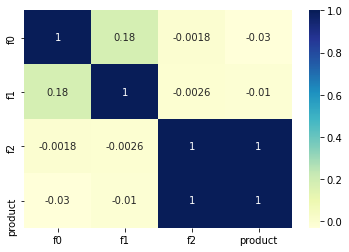

In [12]:
data_plot = sns.heatmap(data_1.corr(), cmap="YlGnBu", annot=True)  
plt.show()

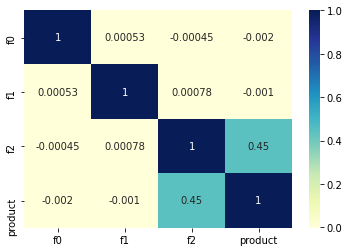

In [13]:
data_plot = sns.heatmap(data_2.corr(), cmap="YlGnBu", annot=True)  
plt.show()

Мультиколлинеарности не наблюдаем. Во втором регионе признак `f2` коррелирует с целевой переменной `product`, этот факт как раз в пользу более точных предсказаний.

In [14]:
print(data_0['id'].duplicated().sum())

10


In [15]:
print(data_1['id'].duplicated().sum())

4


In [16]:
print(data_2['id'].duplicated().sum())

4


Дубликаты по id имеются в каждом регионе. Не ясна их природа появления, поэтому пока оставляем.

## Обучение и проверка модели

**Модель первого региона**

In [18]:
target_0 = data_0['product']
features_0 = data_0.drop(['product', 'id'] , axis=1)
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=12345)

# проведем масштабирование
scaler = MinMaxScaler()
scaler.fit(features_train_0)
features_train_0 = scaler.transform(features_train_0)
features_valid_0 = scaler.transform(features_valid_0)

model = LinearRegression()
model.fit(features_train_0, target_train_0)
predicted_valid_0 = model.predict(features_valid_0)
rmse_0 = mean_squared_error(target_valid_0, predicted_valid_0) ** 0.5

predicted_random = pd.Series(target_train_0.mean(), index=target_valid_0.index) 
rmse_random = mean_squared_error(target_valid_0, predicted_random) ** 0.5

print("RMSE модели =", rmse_0)
print("RMSE случайной модели =", rmse_random)
print("Средний запас предсказанного сырья первого региона =", predicted_valid_0.mean())

RMSE модели = 37.5794217150813
RMSE случайной модели = 44.289591053907365
Средний запас предсказанного сырья первого региона = 92.59256778438035


**Модель второго региона**

In [19]:
target_1 = data_1['product']
features_1 = data_1.drop(['product', 'id'] , axis=1)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=12345)

# проведем масштабирование
scaler = MinMaxScaler()
scaler.fit(features_train_1)
features_train_1 = scaler.transform(features_train_1)
features_valid_1 = scaler.transform(features_valid_1)

model = LinearRegression()
model.fit(features_train_1, target_train_1)
predicted_valid_1 = model.predict(features_valid_1)
rmse_1 = mean_squared_error(target_valid_1, predicted_valid_1) ** 0.5

predicted_random = pd.Series(target_train_1.mean(), index=target_valid_1.index) 
rmse_random = mean_squared_error(target_valid_1, predicted_random) ** 0.5

print("RMSE модели =", rmse_1)
print("RMSE случайной модели =", rmse_random)
print("Средний запас предсказанного сырья второго региона =", predicted_valid_1.mean())

RMSE модели = 0.893099286775617
RMSE случайной модели = 46.02144533725462
Средний запас предсказанного сырья второго региона = 68.72854689544603


**Модель третьего региона**

In [20]:
target_2 = data_2['product']
features_2 = data_2.drop(['product', 'id'] , axis=1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=12345)

# проведем масштабирование
scaler = MinMaxScaler()
scaler.fit(features_train_2)
features_train_2 = scaler.transform(features_train_2)
features_valid_2 = scaler.transform(features_valid_2)

model = LinearRegression()
model.fit(features_train_2, target_train_2)
predicted_valid_2 = model.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predicted_valid_2) ** 0.5

predicted_random = pd.Series(target_train_2.mean(), index=target_valid_2.index) 
rmse_random = mean_squared_error(target_valid_2, predicted_random) ** 0.5

print("RMSE модели =", rmse_2)
print("RMSE случайной модели =", rmse_random)
print("Средний запас предсказанного сырья третьего региона =", predicted_valid_2.mean())

RMSE модели = 40.02970873393434
RMSE случайной модели = 44.90234968510566
Средний запас предсказанного сырья третьего региона = 94.96504596800493


Всех больше среднего предсказанного сырья в третьем регионе. RMSE тоже самое большое у третьей модели. Значения RMSE (корня из средней квадратичной ошибки) у случайной модели и самой модели - стоят рядом у первой модели и третьей, у второй сильно отличаются. В регионах 1 и 3 предсказания практически не отличаются от случайных, значит и доверять им нельзя. Минимальный размер ошибки говорит о хорошей точности предсказаний. 

## Подготовка к расчёту прибыли

Правильные ответы сохранены в target_0 и так далее для трех регионов. Предсказания сохранены в predicted_valid_0 и так далее для каждого отдельного региона. 

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.  
3.3. Напишите выводы по этапу подготовки расчёта прибыли.  

Нужно сравнить полученный объем сырья по каждому региону со средним реальным запасом (тоже отдельно для каждого региона). Нужно рассчитать сколько в среднем должно быть в каждой скважине сырья, чтобы не уйти в убыток при случайном выборе скважин для бурения.   
Чтобы рассчитать достаточный объем сырья, нужно поделить бюджет (10млрд) на доход с каждой единицы продукта (скважины) (450 тыс). И еще учесть, что бюджет на 200 скважин.  

 Достаточный объём сырья для безубыточной разработки новой скважины:

In [21]:
x = 1000000000 / (200*45000)
print(x)

111.11111111111111


In [22]:
print(BUDGET / (POINTS * BENEFIT))

111.11111111111111


In [23]:
data_product_real = pd.concat([data_0['product'], data_1['product'], data_2['product']], sort=False, axis=1).mean()
display(data_product_real)

product    92.500
product    68.825
product    95.000
dtype: float64

In [24]:
col = [['Первый регион', 92.5, 111.11],
      ['Второй регион', 68.82, 111.11], 
      ['Третий регион', 95.00, 111.11]]
col_names = ['Регионы', 'Средний реальный запас', 'Объём сырья для безубыточной скважины']
print(tabulate(col, headers=col_names))

Регионы          Средний реальный запас    Объём сырья для безубыточной скважины
-------------  ------------------------  ---------------------------------------
Первый регион                     92.5                                    111.11
Второй регион                     68.82                                   111.11
Третий регион                     95                                      111.11


Реальный запас 3 региона всех больше близок к безубыточной скважине. 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:  
4.1. Выберите скважины с максимальными значениями предсказаний.  
4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.  
4.3. Рассчитайте прибыль для полученного объёма сырья.

In [25]:
predicted_v_0 = pd.Series(predicted_valid_0, index=target_valid_0.index)
target_v_0 = pd.Series(target_valid_0, index=target_valid_0.index)
#display(predicted_v_0, target_v_0)

predicted_v_1 = pd.Series(predicted_valid_1, index=target_valid_1.index)
target_v_1 = pd.Series(target_valid_1, index=target_valid_1.index)

predicted_v_2 = pd.Series(predicted_valid_2, index=target_valid_2.index)
target_v_2 = pd.Series(target_valid_2, index=target_valid_2.index)

Для расчета прибыли нам надо из выручки вычесть себестоимость(бюджет). 

In [26]:
#функция прибыли
def profit(target, predicted, count):
    predicted_sorted = predicted.sort_values(ascending=False)
    real_sorted= target[predicted_sorted.index][:count]
    return (BENEFIT * real_sorted.sum() - BUDGET)

In [27]:
result = profit(target_v_0, predicted_v_0, 200)
print('Прибыль у перового региона (топ 200 скважин с максимальными значениями) =', result.astype(int))

Прибыль у перового региона (топ 200 скважин с максимальными значениями) = 3320826043


In [28]:
result = profit(target_v_1, predicted_v_1, 200)
print('Прибыль у второго региона (топ 200 скважин с максимальными значениями) =', result.astype(int))

Прибыль у второго региона (топ 200 скважин с максимальными значениями) = 2415086696


In [29]:
result = profit(target_v_2, predicted_v_2, 200)
print('Прибыль у третьего региона (топ 200 скважин с максимальными значениями) =', result.astype(int))

Прибыль у третьего региона (топ 200 скважин с максимальными значениями) = 2710349963


Прибыль больше всех вышла у первого региона, но и третий недалеко ушел.

## Расчёт прибыли и рисков 

In [30]:
#функция для бутстрепа
state = np.random.RandomState(12345)
values = []

for i in range(1000):
    target_subsample = target_v_0.sample(n=500, replace=True, random_state=state)
    probs_subsample = predicted_v_0[target_subsample.index]
    values.append(profit(target_subsample, probs_subsample, 200))

values = pd.Series(values)
lower = values.quantile(q=0.025)
upper = values.quantile(q=0.975)
mean = values.mean()

print('Первый регион')
print('Средняя выручка =', mean.astype(int))
print('2.5% квантиль =', lower.astype(int))
print('97.5% квантиль =', upper.astype(int))

Первый регион
Средняя выручка = 425938526
2.5% квантиль = -102090094
97.5% квантиль = 947976353


Риск это доля отрицательной прибыли в векторе из 1000 прибылей (доля отрицательных значений в векторе values). 

In [32]:
'Риск убытков = {:.2%} '.format((pd.Series(values)<0).mean())

'Риск убытков = 6.00% '

In [33]:
#функция для бутстрепа
state = np.random.RandomState(12345)
values = []

for i in range(1000):
    target_subsample = target_v_1.sample(n=500, replace=True, random_state=state)
    probs_subsample = predicted_v_1[target_subsample.index]
    values.append(profit(target_subsample, probs_subsample, 200))

values = pd.Series(values)
lower = values.quantile(q=0.025)
upper = values.quantile(q=0.975)
mean = values.mean()

print('Второй регион')
print('Средняя выручка =', mean.astype(int))
print('2.5% квантиль =', lower.astype(int))
print('97.5% квантиль =', upper.astype(int))

Второй регион
Средняя выручка = 515222773
2.5% квантиль = 68873225
97.5% квантиль = 931547591


In [34]:
'Риск убытков = {:.2%} '.format((pd.Series(values)<0).mean())

'Риск убытков = 1.00% '

In [35]:
#функция для бутстрепа
state = np.random.RandomState(12345)
values = []

for i in range(1000):
    target_subsample = target_v_2.sample(n=500, replace=True, random_state=state)
    probs_subsample = predicted_v_2[target_subsample.index]
    values.append(profit(target_subsample, probs_subsample, 200))

values = pd.Series(values)
lower = values.quantile(q=0.025)
upper = values.quantile(q=0.975)
mean = values.mean()

print('Третий регион')
print('Средняя выручка =', mean.astype(int))
print('2.5% квантиль =', lower.astype(int))
print('97.5% квантиль =', upper.astype(int))

Третий регион
Средняя выручка = 435008362
2.5% квантиль = -128880547
97.5% квантиль = 969706954


In [36]:
'Риск убытков = {:.2%} '.format((pd.Series(values)<0).mean())

'Риск убытков = 6.40% '

**Вывод:** Судя по убыткам нам подходит лишь второй регион, так как у него риск убытков равен 1%, у других регионов он от 6%, а по условию задачи нам нужны регионы с риском меньше 2.5%. Так же у второго региона вышла самая большая средняя выручка. 
</div>